1. Introduction
2. Import Libraries & Load Data
3. Data Overview
4. Churn Rate Analysis
5. Churn by Contract Type
6. Churn by Tenure
7. Churn vs Monthly Charges
8. Churn vs Support Tickets
9. Key Findings


# Import libraries & load data

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings
pd.set_option("display.max_columns", None)

# Load data
#df = pd.read_csv("../data/customer_churn_data.csv")
df = pd.read_csv("customer_churn_data.csv")


df.head()


,customer_id,tenure_months,contract_type,monthly_charges,support_tickets,payment_method,churn
0,CUST-100000,52,Month-to-Month,58.37,2,Direct Debit,Yes
1,CUST-100001,15,Month-to-Month,66.61,3,Credit Card,Yes
2,CUST-100002,72,Month-to-Month,65.81,1,Bank Transfer,No
3,CUST-100003,61,Month-to-Month,80.22,1,Bank Transfer,Yes
4,CUST-100004,21,One Year,62.59,1,Direct Debit,No


# Customer Churn Analysis – Exploratory Data Analysis

This notebook explores customer churn patterns in a subscription-based business.
The objective is to identify key factors associated with customer attrition and
highlight high-risk customer segments to support retention strategies.


In [61]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      8000 non-null   object 
 1   tenure_months    8000 non-null   int64  
 2   contract_type    8000 non-null   object 
 3   monthly_charges  8000 non-null   float64
 4   support_tickets  8000 non-null   int64  
 5   payment_method   8000 non-null   object 
 6   churn            8000 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 437.6+ KB


In [63]:
df.describe()


,tenure_months,monthly_charges,support_tickets
count,8000.000000,8000.000000,8000.000000
mean,36.423375,65.552806,1.479125
std,20.709201,19.831724,1.206647
min,1.000000,20.000000,0.000000
25%,19.000000,51.840000,1.000000
50%,36.000000,65.475000,1.000000
75%,54.000000,79.102500,2.000000
max,72.000000,150.000000,7.000000


In [65]:
df["churn"].value_counts(normalize=True) * 100


churn
No     69.3
Yes    30.7
Name: proportion, dtype: float64

The dataset contains one record per customer with no missing values.
The churn variable is binary (Yes/No), allowing direct churn rate calculation.


# Overall churn rate

In [69]:
churn_rate = (df["churn"] == "Yes").mean() * 100
churn_rate


30.7

The overall churn rate provides a baseline for evaluating churn across
different customer segments.


# Churn by contract type

In [73]:
churn_by_contract = (
    df.groupby("contract_type")["churn"]
      .apply(lambda x: (x == "Yes").mean() * 100)
      .sort_values(ascending=False)
)

churn_by_contract


contract_type
Month-to-Month    45.576109
One Year          12.597201
Two Year          10.606061
Name: churn, dtype: float64

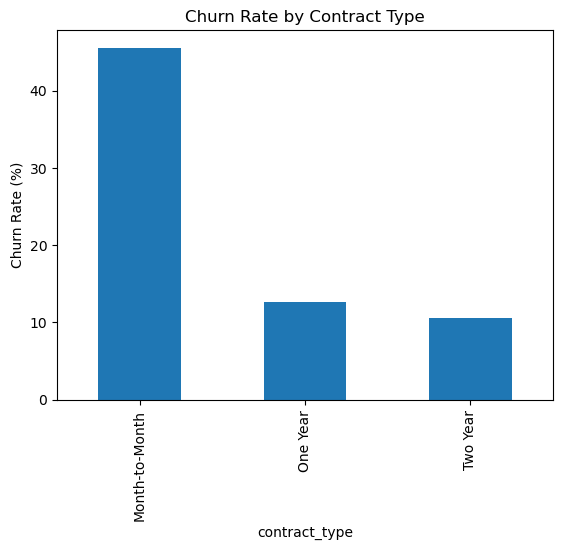

In [75]:
churn_by_contract.plot(kind="bar")
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate (%)")
plt.show()


# Churn by tenure

In [78]:
df["tenure_group"] = pd.cut(
    df["tenure_months"],
    bins=[0, 12, 24, 48, 72],
    labels=["<1 year", "1–2 years", "2–4 years", "4–6 years"]
)
churn_by_tenure = (
    df.groupby("tenure_group", observed=True)["churn"]
      .apply(lambda x: (x == "Yes").mean() * 100)
)

churn_by_tenure


tenure_group
<1 year      50.502707
1–2 years    26.164875
2–4 years    26.946334
4–6 years    27.194299
Name: churn, dtype: float64

churn_by_tenure.plot(kind="bar")
plt.title("Churn Rate by Customer Tenure")
plt.ylabel("Churn Rate (%)")
plt.show()


# Churn vs monthly charges

In [82]:
df.groupby("churn")["monthly_charges"].mean()


churn
No     63.559269
Yes    70.052875
Name: monthly_charges, dtype: float64

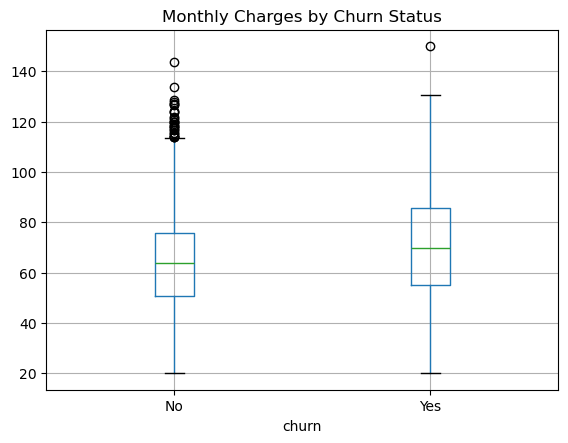

In [84]:
df.boxplot(column="monthly_charges", by="churn")
plt.title("Monthly Charges by Churn Status")
plt.suptitle("")
plt.show()


# Churn vs support tickets

In [87]:
df.groupby("churn")["support_tickets"].mean()


churn
No     1.415043
Yes    1.623779
Name: support_tickets, dtype: float64

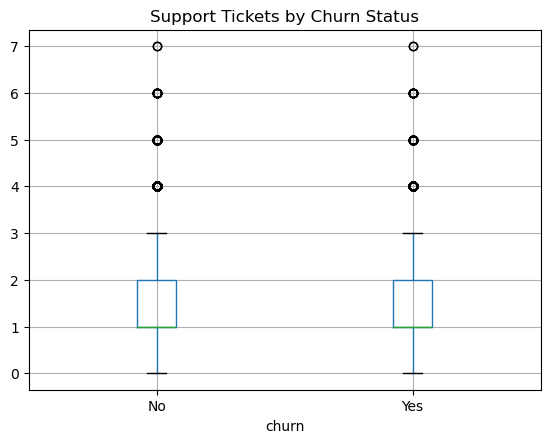

In [89]:
df.boxplot(column="support_tickets", by="churn")
plt.title("Support Tickets by Churn Status")
plt.suptitle("")
plt.show()


## Key Findings

- Customers on month-to-month contracts have the highest churn rates.
- Customers with tenure less than 12 months are significantly more likely to churn.
- Higher monthly charges are associated with increased churn probability.
- Customers with frequent support tickets exhibit elevated churn risk.

These findings indicate that churn is strongly linked to contract structure,
early customer experience, pricing perception, and service quality.


## Churn Risk Scoring


In [93]:
# Calculate average monthly charges
avg_monthly_charges = df["monthly_charges"].mean()

# Initialize risk score
df["churn_risk_score"] = 0

# Rule 1: Contract type
df.loc[df["contract_type"] == "Month-to-Month", "churn_risk_score"] += 3

# Rule 2: Short tenure
df.loc[df["tenure_months"] < 12, "churn_risk_score"] += 2

# Rule 3: High monthly charges
df.loc[df["monthly_charges"] > avg_monthly_charges, "churn_risk_score"] += 2

# Rule 4: Frequent support issues
df.loc[df["support_tickets"] >= 3, "churn_risk_score"] += 2

df[["customer_id", "churn_risk_score"]].head()


,customer_id,churn_risk_score
0,CUST-100000,3
1,CUST-100001,7
2,CUST-100002,5
3,CUST-100003,5
4,CUST-100004,0


## Categorise customers by risk level

In [96]:
df["risk_level"] = pd.cut(
    df["churn_risk_score"],
    bins=[-1, 2, 5, 9],
    labels=["Low", "Medium", "High"]
)

df["risk_level"].value_counts()


risk_level
Medium    4268
Low       2926
High       806
Name: count, dtype: int64

In [98]:
churn_by_risk = (
    df.groupby("risk_level", observed=True)["churn"]
      .apply(lambda x: (x == "Yes").mean() * 100)
)

churn_by_risk


risk_level
Low        7.552973
Medium    40.463918
High      63.027295
Name: churn, dtype: float64

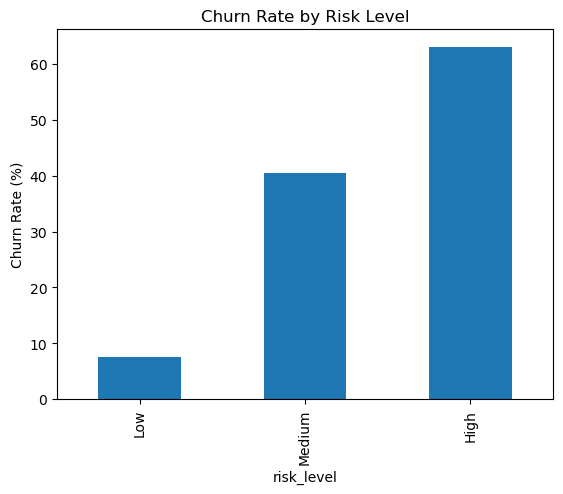

In [100]:
churn_by_risk.plot(kind="bar")
plt.title("Churn Rate by Risk Level")
plt.ylabel("Churn Rate (%)")
plt.show()


### Churn Risk Score Validation

The churn risk score effectively differentiates customers by churn likelihood.
Customers classified as **High Risk** exhibit significantly higher churn rates
compared to Medium and Low Risk segments.

This segmentation enables targeted retention strategies by focusing efforts on
customers with the highest predicted churn risk.


In [103]:
df.to_csv("customer_churn_enriched.csv", index=False)
